# Задание по обработке сигналов

Необходимо разработать, обучить и представить глубокую нейронную сеть, принимающую на вход произвольный сигнал в виде дискретной последовательности $\{s_k\}_{k = 1}^{1024}$, $s \in R$, $t_{k + 1} - t_k = \tau$, и выдающую на выходе оценку **power spectral density (dB)** в виде дискретной последовательности $\{g_k\}_{k = 0}^{512}$. Обучающее и тестовые множества должны иметь нулевое среднее и единичную дисперсию.

In [1]:
import numpy as np
import scipy.signal as signal
import scipy.stats as sts
import random
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, Input, Lambda, Softmax
from keras.models import Sequential
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


2022-05-19 14:21:11.555250: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-19 14:21:11.690461: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-19 14:21:11.691232: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [2]:
class generator:
    def __init__(self, parameters):
        self.__len__ = 1024
        self.sgnl_type, self.tmp = parameters
        self.signal_ = np.zeros(self.__len__); self.t = np.linspace(0, self.__len__, self.__len__) 
        """
        signal types: 
        determined:
            -- periodic signal with frequency f (f = 1 / T where T is period) and amplitude A; ph is #pi-fold.
            -- aperiodic signal with main frequency f and time tau;
            -- non-periodic signals like exponent
        random:
            -- stationary -- gaussian or bernoulli 
            -- non-stationary -- full random
        """
        if self.sgnl_type == "periodic":
            self.A, self.f, self.ph = self.tmp
            self.signal_ = self.A * np.sin(2 * np.pi * self.f * self.t / self.__len__  + np.pi * self.ph)
        
        elif self.sgnl_type == "aperiodic":
            self.A, self.f, self.ph, self.tau = self.tmp
            self.signal_ = self.A * np.sin(2 * np.pi * self.f * self.t / self.__len__ + np.pi * self.ph) * np.exp(- self.t/self.tau)

        elif self.sgnl_type == "non-periodic":
            self.A, self.tau = self.tmp
            self.signal_ = self.A * np.exp(- self.t/self.tau)

        elif self.sgnl_type == "stationary":
            self.A = self.tmp
            self.signal_ = self.A * sts.norm.rvs(size = self.__len__)
        elif self.sgnl_type == "mixed":
            self.A, self.f, self.ph, self.tau = self.tmp
            self.w = 0.01
            self.signal_ = self.A * self.w * sts.norm.rvs(size = self.__len__) + \
             (1 - self.w) * self.A * np.sin(2 * np.pi * self.f * self.t / self.__len__  + np.pi * self.ph) * np.exp(- self.t/self.tau)

    def _make_signal(self):
      return self.signal_, signal.periodogram(self.signal_)[1][:-1]

Сформируем датасет, одновременно генеря несколько типов сигналов.

In [3]:
def get_dataset(n_samples = 2000):
    signal_ = []
    for _ in range(n_samples):
        A = random.uniform(0.0, 20.0)
        f = random.uniform(0.01, 100.0)
        ph = random.uniform(-np.pi /2 , np.pi /2)
        tau = random.uniform(0.1, 5.0)
        signal_.append(generator(("periodic", (A, f, ph)))._make_signal())
        signal_.append(generator(("aperiodic", (A, f, ph, tau)))._make_signal())
        signal_.append(generator(("non-periodic", (A, tau)))._make_signal())
        signal_.append(generator(("stationary", A))._make_signal())
        signal_.append(generator(("mixed", (A, f, ph, tau)))._make_signal())
    X, y =  np.array([a[0] for a in signal_]), np.array([a[1] for a in signal_])
    a, b = X.shape[0], X.shape[1]
    return X, y

Рассмотрим разные модели
* В первой сделаем дополнительно преобразование Фурье и обучение будет идти на нем
* Во второй преобразовние Фурье делать не будем, но немного трансформируем наши данные, нормируя ампитуду(разделив исходный сигнал на амплитуду и домножив квадрат аэтой амплитуды на psd

In [4]:
def evaluate_model(X_train, y_train, X_valid, y_valid):
    verbose, epochs, batch_size = 1, 500, 200
  
    model = Sequential([Input(shape = (1024, 1)), 
                        Flatten(),
                        Lambda(lambda v: tf.cast(tf.signal.rfft(tf.cast(v, dtype = tf.float32)), tf.float32)),
                        Dense(512, use_bias = False),
                        Dropout(0.25),
                        Dense(512, use_bias = False)])
  
    model.compile(loss = 'mean_absolute_error', optimizer = 'adadelta')
    # fit network
    print(model.summary())
    history = model.fit(X_train, y_train, validation_data = (X_valid, y_valid), 
                        epochs = epochs, batch_size = batch_size, verbose = verbose)
   
    return model, history

In [5]:
def evaluate_model2(X_train, y_train, X_valid, y_valid):
    verbose, epochs, batch_size = 1, 500, 200
  
    model = Sequential([Input(shape = (1024, 1)), 
                        Flatten(),
                        Dense(1024, use_bias = False),
                        Dropout(0.25),
                        Dense(512, use_bias = False),
                        Dropout(0.3),
                        Dense(512, use_bias = False)])
  
    model.compile(loss = 'mean_absolute_error', optimizer = 'adadelta')
    # fit network
    print(model.summary())
    history = model.fit(X_train, y_train, validation_data = (X_valid, y_valid), 
                        epochs = epochs, batch_size = batch_size, verbose = verbose)
   
    return model, history

In [6]:
np.random.seed(1)
X_train, y_train = get_dataset(35000)
X_valid, y_valid = get_dataset(5000)
# X_train, y_train = get_dataset(350)
# X_valid, y_valid = get_dataset(50)

In [7]:
model, history = evaluate_model(X_train, y_train, X_valid, y_valid)

2022-05-19 14:22:18.014937: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-19 14:22:18.015397: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-19 14:22:18.016327: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-19 14:22:18.017039: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
lambda (Lambda)              (None, 513)               0         
_________________________________________________________________
dense (Dense)                (None, 512)               262656    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262144    
Total params: 524,800
Trainable params: 524,800
Non-trainable params: 0
_________________________________________________________________
None


2022-05-19 14:22:20.059984: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 716800000 exceeds 10% of free system memory.
2022-05-19 14:22:20.569758: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 716800000 exceeds 10% of free system memory.
2022-05-19 14:22:21.169408: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/500
875/875 [==============================] - 4s 3ms/step - loss: 128.1590 - val_loss: 118.6240
Epoch 2/500
875/875 [==============================] - 2s 2ms/step - loss: 126.5483 - val_loss: 117.2027
Epoch 3/500
875/875 [==============================] - 2s 3ms/step - loss: 125.2846 - val_loss: 116.0380
Epoch 4/500
875/875 [==============================] - 2s 3ms/step - loss: 124.2089 - val_loss: 115.0412
Epoch 5/500
875/875 [==============================] - 2s 2ms/step - loss: 123.2216 - val_loss: 114.1565
Epoch 6/500
875/875 [==============================] - 2s 2ms/step - loss: 122.3133 - val_loss: 113.3429
Epoch 7/500
875/875 [==============================] - 2s 2ms/step - loss: 121.4907 - val_loss: 112.5801
Epoch 8/500
875/875 [==============================] - 2s 2ms/step - loss: 120.6879 - val_loss: 111.8523
Epoch 9/500
875/875 [==============================] - 2s 2ms/step - loss: 119.9123 - val_loss: 111.1548
Epoch 10/500
875/875 [==============================] -

In [8]:
model.save_weights('./checkpoints/model1')

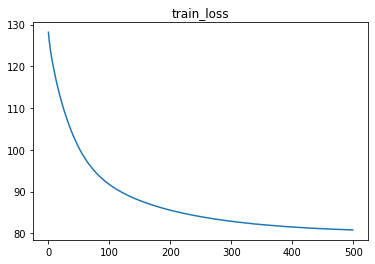

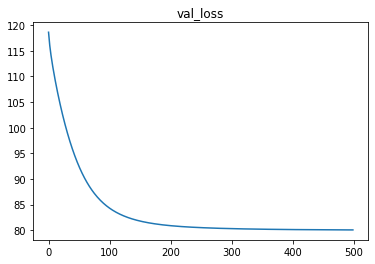

1/1 [==============================] - 0s 63ms/step - loss: 99.3396
99.33964538574219


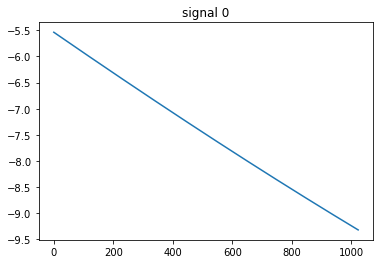

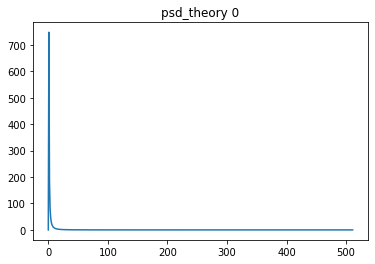

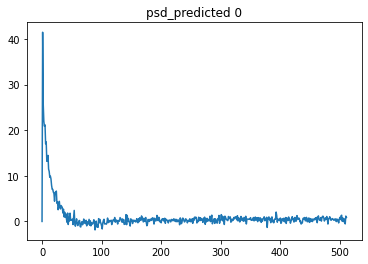

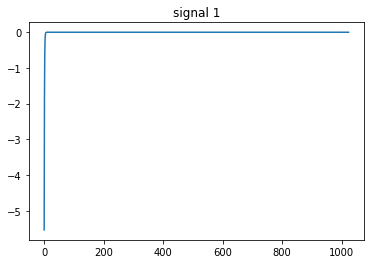

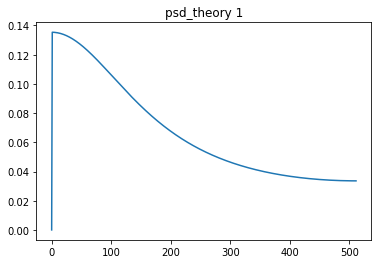

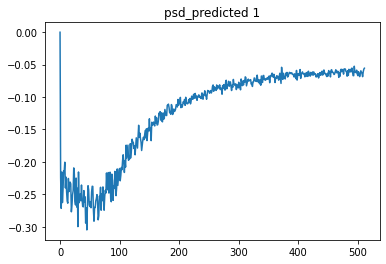

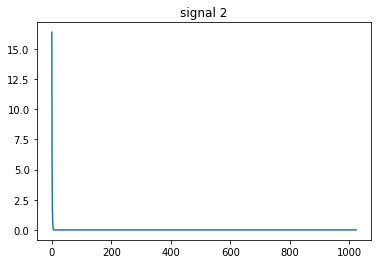

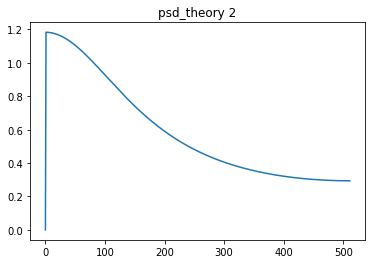

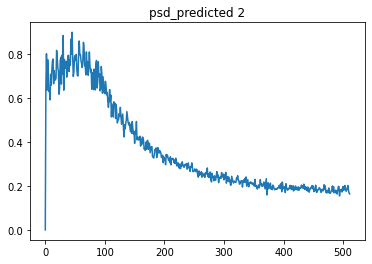

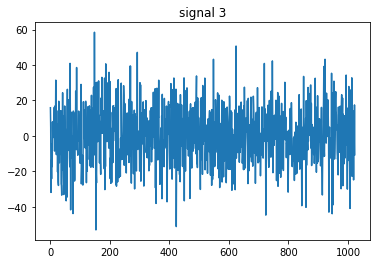

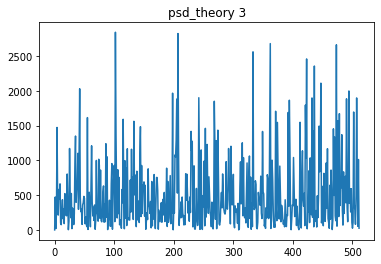

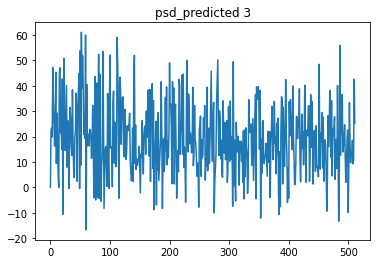

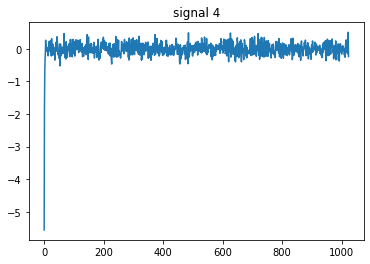

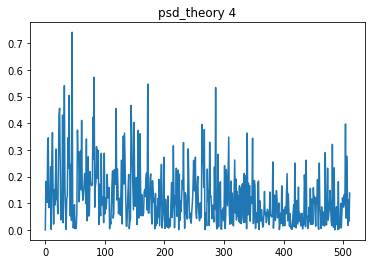

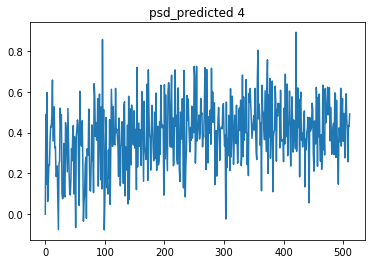

In [9]:
plt.plot(history.history['loss']); plt.title('train_loss'); plt.show()
plt.plot(history.history['val_loss']); plt.title('val_loss'); plt.show()
X_test, y_test = get_dataset(1)
y_pred = model.predict(X_test)

print(model.evaluate(X_test, y_test))
for ind in range(len(y_test)):
  plt.plot(X_test[ind]); plt.title('signal ' + str(ind)); plt.show()
  plt.plot(y_test[ind]); plt.title('psd_theory ' + str(ind)); plt.show()
  plt.plot(y_pred[ind]); plt.title('psd_predicted '+ str(ind)); plt.show()


In [10]:
Amp = np.max(np.abs(X_train), axis = 1)
tild = np.tile(Amp, (1024, 1))
X_train = X_train/tild.T            
y_train = y_train / np.tile(Amp**2, (512, 1)).T

Amp = np.max(np.abs(X_valid), axis = 1)
tild = np.tile(Amp, (1024, 1))
X_valid = X_valid/tild.T            
y_valid = y_valid / np.tile(Amp**2, (512, 1)).T

model, history = evaluate_model2(X_train, y_train, X_valid, y_valid)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              1048576   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               524288    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               262144    
Total params: 1,835,008
Trainable params: 1,835,008
Non-trainable params: 0
____________________________________________

2022-05-19 14:40:30.212205: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 716800000 exceeds 10% of free system memory.
2022-05-19 14:40:31.104521: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 716800000 exceeds 10% of free system memory.


Epoch 1/500
875/875 [==============================] - 2s 2ms/step - loss: 0.4911 - val_loss: 0.4130
Epoch 2/500
875/875 [==============================] - 2s 3ms/step - loss: 0.4881 - val_loss: 0.4101
Epoch 3/500
875/875 [==============================] - 2s 2ms/step - loss: 0.4853 - val_loss: 0.4074
Epoch 4/500
875/875 [==============================] - 2s 2ms/step - loss: 0.4828 - val_loss: 0.4050
Epoch 5/500
875/875 [==============================] - 2s 2ms/step - loss: 0.4805 - val_loss: 0.4029
Epoch 6/500
875/875 [==============================] - 2s 2ms/step - loss: 0.4784 - val_loss: 0.4009
Epoch 7/500
875/875 [==============================] - 2s 2ms/step - loss: 0.4764 - val_loss: 0.3991
Epoch 8/500
875/875 [==============================] - 2s 3ms/step - loss: 0.4747 - val_loss: 0.3974
Epoch 9/500
875/875 [==============================] - 2s 2ms/step - loss: 0.4730 - val_loss: 0.3958
Epoch 10/500
875/875 [==============================] - 2s 2ms/step - loss: 0.4714 - val_lo

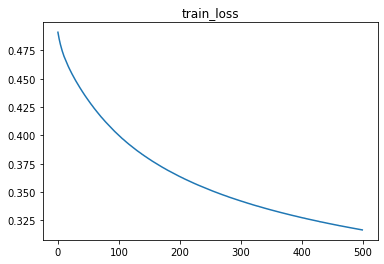

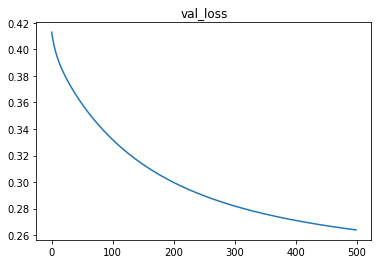

1/1 [==============================] - 0s 60ms/step - loss: 0.2552
0.25519153475761414


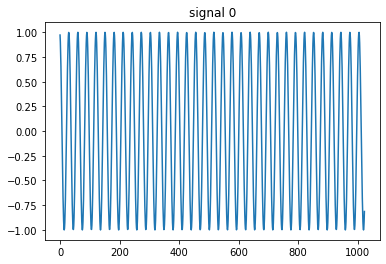

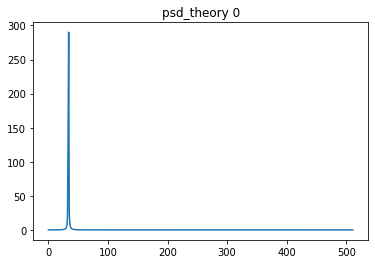

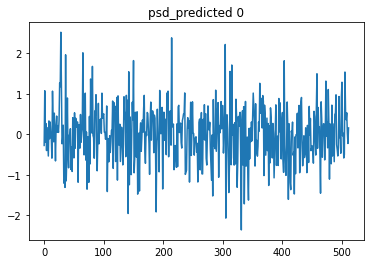

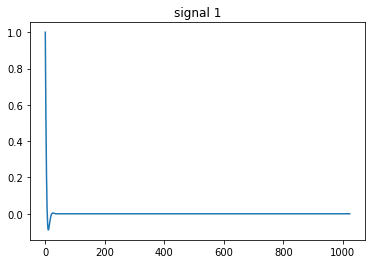

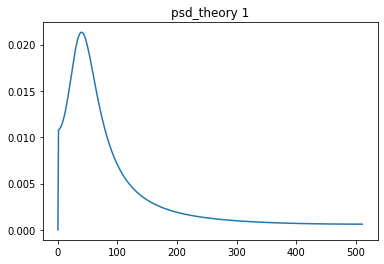

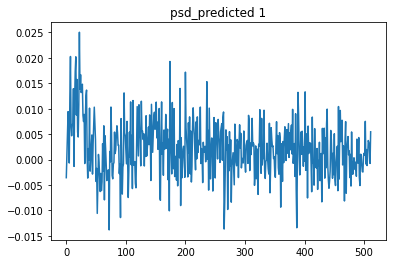

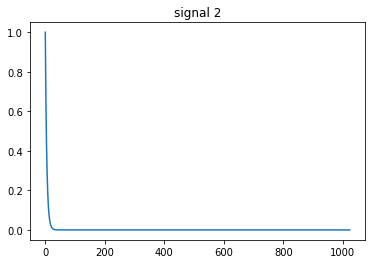

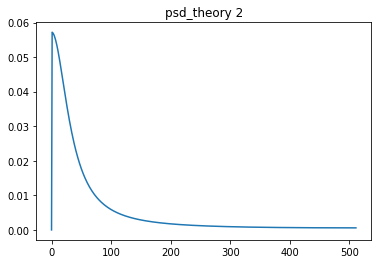

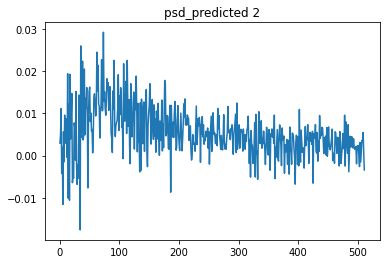

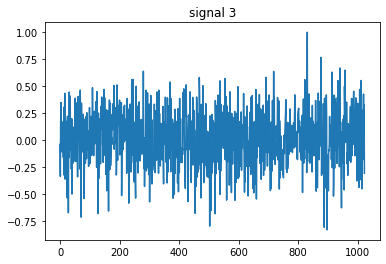

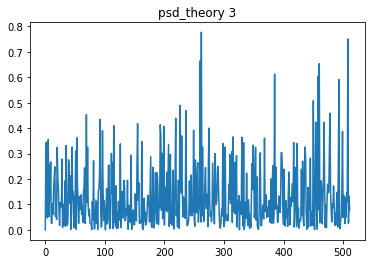

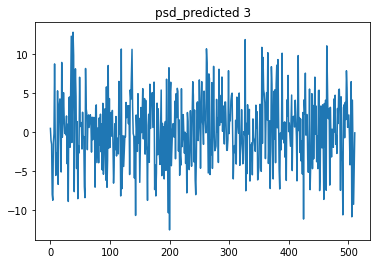

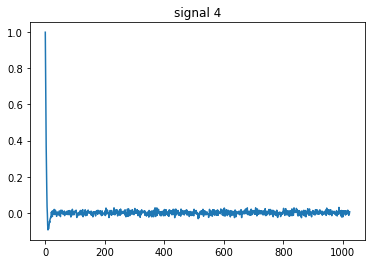

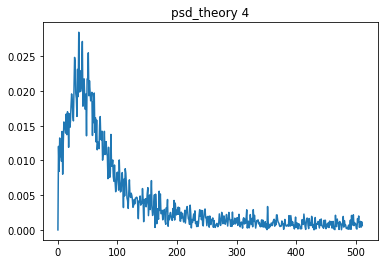

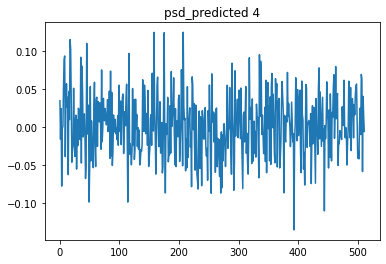

In [11]:
plt.plot(history.history['loss']); plt.title('train_loss'); plt.show()
plt.plot(history.history['val_loss']); plt.title('val_loss'); plt.show()

X_test, y_test = get_dataset(1)
y_pred = model.predict(X_test)

Amp = np.max(np.abs(X_test), axis = 1)
tild = np.tile(Amp, (1024, 1))
X_test = X_test/tild.T            
y_test = y_test / np.tile(Amp**2, (512, 1)).T

print(model.evaluate(X_test, y_test))
for ind in range(len(y_test)):
  plt.plot(X_test[ind]); plt.title('signal ' + str(ind)); plt.show()
  plt.plot(y_test[ind]); plt.title('psd_theory ' + str(ind)); plt.show()
  plt.plot(y_pred[ind]); plt.title('psd_predicted '+ str(ind)); plt.show()
